In [1]:
import os
import sys
import warnings
import subprocess
from subprocess import call
from functools import partial
import statistics

import librosa

from tqdm import tqdm

import numpy as np

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn.functional import pad

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torchmetrics.audio import SignalDistortionRatio

import matplotlib.pyplot as plt

import soundfile

from typing import Tuple

/home/lijm1358/anaconda3/envs/mlenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
# path_folder_in = '../dataset/train'
# path_folder_out = '../dataset/createdmusdb18/train'

# files = os.listdir(path_folder_in)
# for file in tqdm(files, position=0, leave=True):
#   # tqdm.write(f"current song : {file}")
#   file_in = path_folder_in + '/' + file
#   for i in range(5):
#     filesp = file.split(".")
#     filesp[-1] = f"{i}.mp3"
#     filesp = ".".join(filesp)
#     file_out = f"{path_folder_out}/{filesp}"
#     # tqdm.write(f"processing {file_out}", end='\r')
#     call(('ffmpeg', '-y', '-i', file_in, '-map', f'0:{i}', '-vn', file_out),
#          stdout=subprocess.DEVNULL,
#          stderr=subprocess.STDOUT)

In [33]:
# base_dir = '../dataset/createdmusdb18/test'
# target_dir = '../dataset/createdmusdb18/test/data_numpy'
# music_list = os.listdir('../dataset/createdmusdb18/test')
# music_list.sort()

# warnings.filterwarnings('ignore')
# for music in tqdm(music_list):
#     if music != 'data_numpy' and music != 'data_numpy_split':
#         music = os.path.join(base_dir, music)
#         outfile_name = music.split("/")[-1]
#         outfile_name = os.path.join(target_dir, outfile_name)
#         #print(outfile_name)
#         arr, _ = librosa.load(music)
#         np.save(outfile_name, arr)

In [2]:
# base_dir = '../dataset/createdmusdb18/test/data_numpy'
# target_dir = '../dataset/createdmusdb18/test/data_numpy_split'

# # 16384 for training, 22050 for validation/test(1sec length)
# sep_length = 22050

# filelist = os.listdir(base_dir)
# filelist.sort()
# song_np_full = []
# count = 0
# for i, filename in enumerate(tqdm(filelist)):
#     song_np = np.load(os.path.join(base_dir, filename))
#     song_np_full.append(song_np)
#     if i%5==4:
#         song_np_full = np.stack(song_np_full)
#         index = 0
#         while index+sep_length <= song_np_full.shape[1]:
#             np.save(os.path.join(target_dir, str(count)), 
#                     song_np_full[:, index:index+sep_length])
#             index+=sep_length
#             count+=1
#         song_np_full = []

100%|██████████| 250/250 [01:16<00:00,  3.26it/s]


In [2]:
class MUSDBDataset(Dataset):
    def __init__(self, data_dir: str):
        self.music_list = []
        self.data_dir = os.path.join(data_dir, 'data_numpy_split')
        self.music_list = self.get_filenames(self.data_dir)

    def __len__(self):
        return len(self.music_list)

    def __getitem__(self, idx):
        music = self.music_list[idx]
        music = np.load(music)
        return np.expand_dims(music[0], 0), music[1:]

    def get_filenames(self, path):
        files_list = list()
        filenames = os.listdir(path)
        filenames.sort()
        for filename in filenames:
            files_list.append(os.path.join(path, filename))
        return files_list

In [3]:
train_ds = MUSDBDataset('../dataset/createdmusdb18/train')
test_ds = MUSDBDataset('../dataset/createdmusdb18/test')

In [4]:
valid_ds, test_ds = random_split(test_ds, [int(len(test_ds)*0.5), len(test_ds) - int(len(test_ds)*0.5)])

In [5]:
train_dataloader = DataLoader(train_ds, batch_size=16)
valid_dataloader = DataLoader(valid_ds, batch_size=16)
test_dataloader = DataLoader(test_ds, batch_size=16)

In [6]:
class DownSampling(nn.Module):
    def __init__(self, in_ch=1, out_ch=24, kernel_size=15):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size=kernel_size, padding=7),
            nn.LeakyReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, kernel_size=kernel_size, padding=7),
            nn.LeakyReLU(inplace=True),
        )
        
    def forward(self, x: Tensor):
        x = self.net(x)
        return x

In [7]:
class UpSampling(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode="linear", align_corners=True)
        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size=kernel_size, padding=2),
            nn.LeakyReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, kernel_size=kernel_size, padding=2),
            nn.LeakyReLU(inplace=True),
        )
        
    def forward(self, x, x_back):
        x = self.upsample(x)
        diff = x_back.shape[-1] - x.shape[-1]
        x = pad(x, (0, diff))
        x = torch.cat([x, x_back], axis=1)
        return self.conv(x)

In [8]:
class WaveUNet(nn.Module):
    def __init__(self, n_level=12, n_source=4):
        super().__init__()
        self.level = n_level
        
        layers=[DownSampling(in_ch=1,out_ch=24,kernel_size=15)]
        
        for i in range(self.level-1):
            layers.append(DownSampling(in_ch=24*(i+1),out_ch=24*(i+2),kernel_size=15))
            
        # layers.append(DownSampling(in_ch=24*(self.level), out_ch=24*(self.level+1), kernel_size=15, decimate=False))
        layers.append(DownSampling(in_ch=24*(self.level), out_ch=24*(self.level+1), kernel_size=15))
            
        for i in range(self.level):
            layers.append(UpSampling(in_ch=24*(self.level+1-i) + 24*(self.level - i), out_ch=24*(self.level-i), kernel_size=5))
            
        self.net = nn.ModuleList(layers)
        self.separation = nn.Sequential(
            nn.Conv1d(25, n_source, kernel_size=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv1d(n_source, n_source, kernel_size=1),
            nn.LeakyReLU(inplace=True),
        )
    
    def forward(self, x: Tensor):
        layer_to_concat = []
        # print("before in ", x.shape)
        layer_to_concat.append(x)
        for layer in self.net[0: self.level]:
            x = layer(x)
            # print("conv ", x.shape)
            layer_to_concat.append(x)
            x = x[:, :, 1::2]
            # print("decimate ", x.shape)
        x = self.net[self.level](x)
        # print("middle out ", x.shape)
        layer_to_concat.append(x)
        for i, layer in enumerate(self.net[self.level+1:]):
            # print("before up ", x.shape)
            x = layer_to_concat[-1]
            x = layer(x, layer_to_concat[-1-i-1])
            # print("after up ", x.shape)
            layer_to_concat[-1] = x
            
        x = torch.cat([layer_to_concat[0], x], axis=1)
        x = self.separation(x)

        return x

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [10]:
class EarlyStopping:
    def __init__(self, patience, path='checkpoint.pt'):
        self.patience = patience
        self.best_loss = -np.inf
        self.counter = 0
        self.path = path
        self.early_stop = False
    
    def __call__(self, val_loss, model):
        if self.best_loss < val_loss:
            print(f'Validation loss improved({self.best_loss} -> {val_loss})')
            self.counter = 0
            self.best_loss = val_loss
            torch.save(model.state_dict(), self.path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def is_stop(self):
        return self.early_stop

In [11]:
model = WaveUNet(n_level=12).to(device)
# print(model)

In [12]:
from torchmetrics.functional.audio.sdr import signal_distortion_ratio

class ModifiedSDR(SignalDistortionRatio):
    def update(self, preds: Tensor, target: Tensor) -> None:
        sdr_batch = signal_distortion_ratio(
            preds, target, self.use_cg_iter, self.filter_length, self.zero_mean, self.load_diag
        )

        self.sdr_batch = sdr_batch
        self.sum_sdr += sdr_batch.sum()

    def compute(self) -> Tuple[Tensor, Tensor]:
        return self.sum_sdr, self.sdr_batch

In [13]:
loss_fn = nn.MSELoss()
test_loss_fn = ModifiedSDR().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=[0.9, 0.999])

early_stop = EarlyStopping(patience=20, path='checkpoint/best.pt')

In [14]:
def sdr_loss_mean(y_target, y_pred, loss_fn) -> Tuple[float, list, int]:
    y_target_acc = y_target[:, 0:3]
    y_target_acc = torch.flatten(y_target_acc, end_dim=1)
    y_pred_acc = y_pred[:, 0:3]
    y_pred_acc = torch.flatten(y_pred_acc, end_dim=1)

    y_target_voc = y_target[:, 3]
    y_pred_voc = y_pred[:, 3]

    # remove tensor element only consists of zero.
    mask = (y_target_acc != 0).any(dim=1)   
    y_target_acc = y_target_acc[mask]
    y_pred_acc = y_pred_acc[mask]

    mask = (y_target_voc != 0).any(dim=1)
    y_target_voc = y_target_voc[mask]
    y_pred_voc = y_pred_voc[mask]

    loss_acc = loss_fn(y_pred_acc, y_target_acc)[0].item()
    loss_voc = loss_fn(y_pred_voc, y_target_voc)[1]

    return loss_acc, loss_voc, y_target_acc.shape[0]


In [15]:
train_loss_list = []
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    loss_avg = 0
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_avg += loss.item()
        
        # if batch*len(X) % 800 == 0:
        #    print(f"loss : {loss.item()} ({batch*len(X)}/{size})")
    loss_avg = loss_avg / len(dataloader)
    train_loss_list.append(loss_avg)
    print(f"train loss : {loss_avg}")

In [16]:
val_loss_list = []
def val(dataloader, model, loss_fn):
    model.eval()
    val_loss_acc = 0
    val_loss_voc = []
    data_count = 0
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            acc_loss, voc_loss, count = sdr_loss_mean(y, pred, loss_fn)
            val_loss_acc += acc_loss
            val_loss_voc += voc_loss
            data_count += count
    val_loss_acc /= data_count
    val_loss_voc = statistics.median(val_loss_voc)
    early_stop(val_loss_acc, model) # only accompanies' sdr will be used for early stopping.
    val_loss_list.append(val_loss_acc)
    print(f"validation loss : {val_loss_acc} (accompanies loss, mean), {val_loss_voc} (vocal loss, median)\n")


In [17]:
def test(dataloader, model, loss_fn):
    model.eval()
    test_loss_acc = 0
    test_loss_voc = []
    data_count = 0
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            acc_loss, voc_loss, count = sdr_loss_mean(y, pred, loss_fn)
            test_loss_acc += acc_loss
            test_loss_voc += voc_loss
            data_count += count
    test_loss_acc /= data_count
    test_loss_voc = statistics.median(test_loss_voc)
    print(f"test loss : {test_loss_acc} (accompanies loss, mean), {test_loss_voc} (vocal loss, median)\n")

In [24]:
checkpoint = torch.load('checkpoint/checkpoint_epoch23')

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
early_stop.best_loss = checkpoint['earlystop_bestloss']
early_stop.counter = checkpoint['earlystop_counter']

train_loss_list = checkpoint['train_losslist']
val_loss_list = checkpoint['val_losslist']

start_epoch = checkpoint['epoch']

In [25]:
val(valid_dataloader, model, test_loss_fn)

100%|██████████| 389/389 [00:58<00:00,  6.63it/s]


Validation loss improved(-1.4704411668406976 -> -1.4518170610262389)
validation loss : -1.4518170610262389 (accompanies loss, mean), -0.827527642250061 (vocal loss, median)



In [28]:
epochs = 200
for t in range(start_epoch+1, epochs):
    print(f"epoch : {t+1}\n---------------------------")
    model.train()
    train(train_dataloader, model, loss_fn, optimizer)
    val(valid_dataloader, model, test_loss_fn)

    if early_stop.is_stop():
        print("Early stop. Loading best model...")
        model.load_state_dict(torch.load('checkpoint/best.pt'))
        break

    torch.save({
        'epoch': t+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'earlystop_bestloss': early_stop.best_loss,
        'earlystop_counter': early_stop.counter,
        'train_losslist': train_loss_list,
        'val_losslist': val_loss_list
    }, f'checkpoint/checkpoint_epoch{t+1}')

    try:
        os.remove(f'checkpoint/checkpoint_epoch{t}')
    except OSError:
        pass
    
test(test_dataloader, model, test_loss_fn)

epoch : 25
---------------------------


100%|██████████| 1921/1921 [09:13<00:00,  3.47it/s]


train loss : 0.001564995738756076


100%|██████████| 389/389 [00:58<00:00,  6.69it/s]


Validation loss improved(-1.4518170610262389 -> -1.380292035323095)
validation loss : -1.380292035323095 (accompanies loss, mean), -0.7667863965034485 (vocal loss, median)

epoch : 26
---------------------------


100%|██████████| 1921/1921 [09:10<00:00,  3.49it/s]


train loss : 0.0015487116417829288


100%|██████████| 389/389 [01:03<00:00,  6.13it/s]


Validation loss improved(-1.380292035323095 -> -1.3204353722709843)
validation loss : -1.3204353722709843 (accompanies loss, mean), -0.9163544774055481 (vocal loss, median)

epoch : 27
---------------------------


100%|██████████| 1921/1921 [09:07<00:00,  3.51it/s]


train loss : 0.0015368117260175


100%|██████████| 389/389 [01:15<00:00,  5.13it/s]


validation loss : -1.3567086781734319 (accompanies loss, mean), -1.214671015739441 (vocal loss, median)

epoch : 28
---------------------------


100%|██████████| 1921/1921 [08:59<00:00,  3.56it/s]


train loss : 0.0015220990394671594


100%|██████████| 389/389 [01:16<00:00,  5.11it/s]


Validation loss improved(-1.3204353722709843 -> -1.282679025676857)
validation loss : -1.282679025676857 (accompanies loss, mean), -1.06052565574646 (vocal loss, median)

epoch : 29
---------------------------


100%|██████████| 1921/1921 [08:56<00:00,  3.58it/s]


train loss : 0.001509402202585035


100%|██████████| 389/389 [01:11<00:00,  5.48it/s]


Validation loss improved(-1.282679025676857 -> -1.2068704579387992)
validation loss : -1.2068704579387992 (accompanies loss, mean), -1.2193220853805542 (vocal loss, median)

epoch : 30
---------------------------


100%|██████████| 1921/1921 [09:09<00:00,  3.50it/s]


train loss : 0.0014925937767946674


100%|██████████| 389/389 [01:08<00:00,  5.69it/s]


Validation loss improved(-1.2068704579387992 -> -1.0495144482514225)
validation loss : -1.0495144482514225 (accompanies loss, mean), -1.2437537908554077 (vocal loss, median)

epoch : 31
---------------------------


100%|██████████| 1921/1921 [08:47<00:00,  3.64it/s]


train loss : 0.0014727052823610416


100%|██████████| 389/389 [01:15<00:00,  5.18it/s]


Validation loss improved(-1.0495144482514225 -> -1.0421157694505778)
validation loss : -1.0421157694505778 (accompanies loss, mean), -1.1660497188568115 (vocal loss, median)

epoch : 32
---------------------------


100%|██████████| 1921/1921 [08:55<00:00,  3.59it/s]


train loss : 0.001454049202486259


100%|██████████| 389/389 [01:07<00:00,  5.76it/s]


Validation loss improved(-1.0421157694505778 -> -0.8925157434915183)
validation loss : -0.8925157434915183 (accompanies loss, mean), -1.1602317094802856 (vocal loss, median)

epoch : 33
---------------------------


100%|██████████| 1921/1921 [09:11<00:00,  3.48it/s]


train loss : 0.001432320923312773


100%|██████████| 389/389 [01:11<00:00,  5.44it/s]


Validation loss improved(-0.8925157434915183 -> -0.7980909912136207)
validation loss : -0.7980909912136207 (accompanies loss, mean), -1.0651788711547852 (vocal loss, median)

epoch : 34
---------------------------


100%|██████████| 1921/1921 [08:53<00:00,  3.60it/s]


train loss : 0.0014184323541547022


100%|██████████| 389/389 [01:16<00:00,  5.11it/s]


validation loss : -0.9986630979344546 (accompanies loss, mean), -1.0217247009277344 (vocal loss, median)

epoch : 35
---------------------------


100%|██████████| 1921/1921 [08:52<00:00,  3.61it/s]


train loss : 0.0014003114339766565


100%|██████████| 389/389 [01:09<00:00,  5.60it/s]


validation loss : -0.8871145981487328 (accompanies loss, mean), -0.8552269339561462 (vocal loss, median)

epoch : 36
---------------------------


100%|██████████| 1921/1921 [09:08<00:00,  3.50it/s]


train loss : 0.0013884397580537938


100%|██████████| 389/389 [01:05<00:00,  5.91it/s]


Validation loss improved(-0.7980909912136207 -> -0.6390449578010183)
validation loss : -0.6390449578010183 (accompanies loss, mean), -0.8925269842147827 (vocal loss, median)

epoch : 37
---------------------------


100%|██████████| 1921/1921 [09:04<00:00,  3.53it/s]


train loss : 0.0013683473587562205


100%|██████████| 389/389 [01:16<00:00,  5.07it/s]


validation loss : -0.7071262525086666 (accompanies loss, mean), -0.6717513203620911 (vocal loss, median)

epoch : 38
---------------------------


100%|██████████| 1921/1921 [08:48<00:00,  3.64it/s]


train loss : 0.0013523277705673785


100%|██████████| 389/389 [01:17<00:00,  5.05it/s]


Validation loss improved(-0.6390449578010183 -> -0.6064823700842237)
validation loss : -0.6064823700842237 (accompanies loss, mean), -0.6855601668357849 (vocal loss, median)

epoch : 39
---------------------------


100%|██████████| 1921/1921 [08:57<00:00,  3.57it/s]


train loss : 0.0013327979443721399


100%|██████████| 389/389 [01:11<00:00,  5.43it/s]


validation loss : -0.6729804854739593 (accompanies loss, mean), -0.6533651351928711 (vocal loss, median)

epoch : 40
---------------------------


100%|██████████| 1921/1921 [09:04<00:00,  3.53it/s]


train loss : 0.0013213478977183004


100%|██████████| 389/389 [01:15<00:00,  5.17it/s]


Validation loss improved(-0.6064823700842237 -> -0.5390106010688567)
validation loss : -0.5390106010688567 (accompanies loss, mean), -0.7004085779190063 (vocal loss, median)

epoch : 41
---------------------------


100%|██████████| 1921/1921 [08:46<00:00,  3.65it/s]


train loss : 0.0013045892091636936


100%|██████████| 389/389 [01:13<00:00,  5.26it/s]


Validation loss improved(-0.5390106010688567 -> -0.46850216425038166)
validation loss : -0.46850216425038166 (accompanies loss, mean), -0.6131467819213867 (vocal loss, median)

epoch : 42
---------------------------


100%|██████████| 1921/1921 [09:00<00:00,  3.55it/s]


train loss : 0.0012842901765426275


100%|██████████| 389/389 [01:01<00:00,  6.30it/s]


validation loss : -0.47189926588241826 (accompanies loss, mean), -0.5524277091026306 (vocal loss, median)

epoch : 43
---------------------------


100%|██████████| 1921/1921 [09:06<00:00,  3.52it/s]


train loss : 0.0012697820688363129


100%|██████████| 389/389 [01:17<00:00,  5.00it/s]


Validation loss improved(-0.46850216425038166 -> -0.4066763843908679)
validation loss : -0.4066763843908679 (accompanies loss, mean), -0.6458346247673035 (vocal loss, median)

epoch : 44
---------------------------


100%|██████████| 1921/1921 [08:43<00:00,  3.67it/s]


train loss : 0.0012708345824963584


100%|██████████| 389/389 [01:15<00:00,  5.14it/s]


Validation loss improved(-0.4066763843908679 -> -0.3229318436676285)
validation loss : -0.3229318436676285 (accompanies loss, mean), -0.6814343929290771 (vocal loss, median)

epoch : 45
---------------------------


100%|██████████| 1921/1921 [08:55<00:00,  3.59it/s]


train loss : 0.0012516560645360127


100%|██████████| 389/389 [01:09<00:00,  5.57it/s]


Validation loss improved(-0.3229318436676285 -> -0.2903461952841156)
validation loss : -0.2903461952841156 (accompanies loss, mean), -0.5283935070037842 (vocal loss, median)

epoch : 46
---------------------------


100%|██████████| 1921/1921 [09:02<00:00,  3.54it/s]


train loss : 0.0012373094092928368


100%|██████████| 389/389 [01:16<00:00,  5.09it/s]


validation loss : -0.38970782176830565 (accompanies loss, mean), -0.43264713883399963 (vocal loss, median)

epoch : 47
---------------------------


100%|██████████| 1921/1921 [08:40<00:00,  3.69it/s]


train loss : 0.0012203566501162127


100%|██████████| 389/389 [01:16<00:00,  5.06it/s]


validation loss : -0.3205210106733396 (accompanies loss, mean), -0.384259432554245 (vocal loss, median)

epoch : 48
---------------------------


100%|██████████| 1921/1921 [08:56<00:00,  3.58it/s]


train loss : 0.001207880263951383


100%|██████████| 389/389 [01:11<00:00,  5.41it/s]


validation loss : -0.4669784240118923 (accompanies loss, mean), -0.3402026295661926 (vocal loss, median)

epoch : 49
---------------------------


100%|██████████| 1921/1921 [09:02<00:00,  3.54it/s]


train loss : 0.0011975974004606604


100%|██████████| 389/389 [01:14<00:00,  5.20it/s]


validation loss : -0.4561036537149168 (accompanies loss, mean), -0.4432608485221863 (vocal loss, median)

epoch : 50
---------------------------


100%|██████████| 1921/1921 [08:43<00:00,  3.67it/s]


train loss : 0.0011831343560197805


100%|██████████| 389/389 [01:15<00:00,  5.19it/s]


validation loss : -0.508805311019647 (accompanies loss, mean), -0.2933991551399231 (vocal loss, median)

epoch : 51
---------------------------


100%|██████████| 1921/1921 [09:03<00:00,  3.53it/s]


train loss : 0.001168214790212851


100%|██████████| 389/389 [01:03<00:00,  6.14it/s]


validation loss : -0.36407105017099683 (accompanies loss, mean), -0.2939088046550751 (vocal loss, median)

epoch : 52
---------------------------


100%|██████████| 1921/1921 [09:01<00:00,  3.55it/s]


train loss : 0.0011572824098343855


100%|██████████| 389/389 [01:18<00:00,  4.97it/s]


validation loss : -0.41089587017352247 (accompanies loss, mean), -0.17414997518062592 (vocal loss, median)

epoch : 53
---------------------------


100%|██████████| 1921/1921 [08:43<00:00,  3.67it/s]


train loss : 0.0011505436586740454


100%|██████████| 389/389 [01:14<00:00,  5.25it/s]


validation loss : -0.4226057034164912 (accompanies loss, mean), -0.26651591062545776 (vocal loss, median)

epoch : 54
---------------------------


100%|██████████| 1921/1921 [09:06<00:00,  3.51it/s]


train loss : 0.001140691973886436


100%|██████████| 389/389 [01:03<00:00,  6.10it/s]


validation loss : -0.4967290407887377 (accompanies loss, mean), -0.21527624130249023 (vocal loss, median)

epoch : 55
---------------------------


100%|██████████| 1921/1921 [08:51<00:00,  3.61it/s]


train loss : 0.0011352456574322033


100%|██████████| 389/389 [01:17<00:00,  5.05it/s]


validation loss : -0.4471427231153598 (accompanies loss, mean), -0.07446020841598511 (vocal loss, median)

epoch : 56
---------------------------


100%|██████████| 1921/1921 [08:44<00:00,  3.66it/s]


train loss : 0.0011286075808201645


100%|██████████| 389/389 [01:13<00:00,  5.29it/s]


validation loss : -0.347207726962681 (accompanies loss, mean), -0.08895508944988251 (vocal loss, median)

epoch : 57
---------------------------


100%|██████████| 1921/1921 [09:10<00:00,  3.49it/s]


train loss : 0.0011139849853092133


100%|██████████| 389/389 [01:00<00:00,  6.45it/s]


validation loss : -0.38328568885083214 (accompanies loss, mean), -0.09046626091003418 (vocal loss, median)

epoch : 58
---------------------------


100%|██████████| 1921/1921 [08:53<00:00,  3.60it/s]


train loss : 0.0011017371454273572


100%|██████████| 389/389 [01:16<00:00,  5.07it/s]


Validation loss improved(-0.2903461952841156 -> -0.2778525656021494)
validation loss : -0.2778525656021494 (accompanies loss, mean), -0.18240126967430115 (vocal loss, median)

epoch : 59
---------------------------


100%|██████████| 1921/1921 [08:43<00:00,  3.67it/s]


train loss : 0.0010847943679038934


100%|██████████| 389/389 [01:12<00:00,  5.40it/s]


validation loss : -0.48996544447481843 (accompanies loss, mean), -0.04330801963806152 (vocal loss, median)

epoch : 60
---------------------------


100%|██████████| 1921/1921 [09:06<00:00,  3.52it/s]


train loss : 0.001077112037896929


100%|██████████| 389/389 [00:58<00:00,  6.68it/s]


validation loss : -0.2786672040977344 (accompanies loss, mean), -0.037723176181316376 (vocal loss, median)

epoch : 61
---------------------------


100%|██████████| 1921/1921 [09:01<00:00,  3.55it/s]


train loss : 0.0010751172083119508


100%|██████████| 389/389 [01:16<00:00,  5.09it/s]


Validation loss improved(-0.2778525656021494 -> -0.23642618586281958)
validation loss : -0.23642618586281958 (accompanies loss, mean), -0.10895343124866486 (vocal loss, median)

epoch : 62
---------------------------


100%|██████████| 1921/1921 [08:48<00:00,  3.64it/s]


train loss : 0.0010645700480498553


100%|██████████| 389/389 [01:16<00:00,  5.08it/s]


validation loss : -0.2646377873448666 (accompanies loss, mean), -0.1829526424407959 (vocal loss, median)

epoch : 63
---------------------------


100%|██████████| 1921/1921 [09:00<00:00,  3.56it/s]


train loss : 0.0010683687589830013


100%|██████████| 389/389 [01:11<00:00,  5.46it/s]


Validation loss improved(-0.23642618586281958 -> -0.13820043485022093)
validation loss : -0.13820043485022093 (accompanies loss, mean), -0.2506113350391388 (vocal loss, median)

epoch : 64
---------------------------


100%|██████████| 1921/1921 [09:00<00:00,  3.55it/s]


train loss : 0.0010677890277229721


100%|██████████| 389/389 [01:17<00:00,  5.02it/s]


validation loss : -0.21054977061181107 (accompanies loss, mean), -0.39568662643432617 (vocal loss, median)

epoch : 65
---------------------------


100%|██████████| 1921/1921 [08:47<00:00,  3.64it/s]


train loss : 0.0010545238631997098


100%|██████████| 389/389 [01:14<00:00,  5.23it/s]


Validation loss improved(-0.13820043485022093 -> -0.0954529519237639)
validation loss : -0.0954529519237639 (accompanies loss, mean), -0.3890991806983948 (vocal loss, median)

epoch : 66
---------------------------


100%|██████████| 1921/1921 [09:06<00:00,  3.52it/s]


train loss : 0.001042508291061045


100%|██████████| 389/389 [01:00<00:00,  6.39it/s]


Validation loss improved(-0.0954529519237639 -> -0.07673083181817254)
validation loss : -0.07673083181817254 (accompanies loss, mean), -0.5360231995582581 (vocal loss, median)

epoch : 67
---------------------------


100%|██████████| 1921/1921 [09:00<00:00,  3.55it/s]


train loss : 0.0010310497205123102


100%|██████████| 389/389 [01:17<00:00,  5.02it/s]


Validation loss improved(-0.07673083181817254 -> 0.07276475760749468)
validation loss : 0.07276475760749468 (accompanies loss, mean), -0.7372639775276184 (vocal loss, median)

epoch : 68
---------------------------


100%|██████████| 1921/1921 [08:43<00:00,  3.67it/s]


train loss : 0.001014808102422317


100%|██████████| 389/389 [01:15<00:00,  5.16it/s]


validation loss : 0.054143823772354396 (accompanies loss, mean), -0.5486474633216858 (vocal loss, median)

epoch : 69
---------------------------


100%|██████████| 1921/1921 [09:03<00:00,  3.54it/s]


train loss : 0.001017301346173331


100%|██████████| 389/389 [01:05<00:00,  5.91it/s]


validation loss : 0.007052457570191145 (accompanies loss, mean), -0.6899881958961487 (vocal loss, median)

epoch : 70
---------------------------


100%|██████████| 1921/1921 [09:00<00:00,  3.55it/s]


train loss : 0.0010165887058507894


100%|██████████| 389/389 [01:18<00:00,  4.98it/s]


Validation loss improved(0.07276475760749468 -> 0.13177189926189947)
validation loss : 0.13177189926189947 (accompanies loss, mean), -0.36075788736343384 (vocal loss, median)

epoch : 71
---------------------------


100%|██████████| 1921/1921 [08:43<00:00,  3.67it/s]


train loss : 0.0010148369448480887


100%|██████████| 389/389 [01:15<00:00,  5.12it/s]


validation loss : -0.029041843565239856 (accompanies loss, mean), -0.5782281756401062 (vocal loss, median)

epoch : 72
---------------------------


100%|██████████| 1921/1921 [08:59<00:00,  3.56it/s]


train loss : 0.0009922818390959913


100%|██████████| 389/389 [01:07<00:00,  5.75it/s]


Validation loss improved(0.13177189926189947 -> 0.25111415675488613)
validation loss : 0.25111415675488613 (accompanies loss, mean), -0.5805948376655579 (vocal loss, median)

epoch : 73
---------------------------


100%|██████████| 1921/1921 [09:05<00:00,  3.52it/s]


train loss : 0.0009804374193503034


100%|██████████| 389/389 [01:15<00:00,  5.15it/s]


validation loss : 0.20718719022914087 (accompanies loss, mean), -0.7333612442016602 (vocal loss, median)

epoch : 74
---------------------------


100%|██████████| 1921/1921 [08:48<00:00,  3.64it/s]


train loss : 0.00097725517451156


100%|██████████| 389/389 [01:14<00:00,  5.19it/s]


Validation loss improved(0.25111415675488613 -> 0.2634499356168096)
validation loss : 0.2634499356168096 (accompanies loss, mean), -0.653320848941803 (vocal loss, median)

epoch : 75
---------------------------


100%|██████████| 1921/1921 [08:55<00:00,  3.59it/s]


train loss : 0.0009653003580070063


100%|██████████| 389/389 [01:05<00:00,  5.97it/s]


Validation loss improved(0.2634499356168096 -> 0.3393128142546937)
validation loss : 0.3393128142546937 (accompanies loss, mean), -1.0594760179519653 (vocal loss, median)

epoch : 76
---------------------------


100%|██████████| 1921/1921 [09:11<00:00,  3.48it/s]


train loss : 0.0009728553778574192


100%|██████████| 389/389 [01:09<00:00,  5.61it/s]


validation loss : 0.2570465742912829 (accompanies loss, mean), -0.15302635729312897 (vocal loss, median)

epoch : 77
---------------------------


100%|██████████| 1921/1921 [08:52<00:00,  3.61it/s]


train loss : 0.0009552904550512729


100%|██████████| 389/389 [01:16<00:00,  5.07it/s]


validation loss : 0.29175953867846327 (accompanies loss, mean), -0.2903846502304077 (vocal loss, median)

epoch : 78
---------------------------


100%|██████████| 1921/1921 [08:51<00:00,  3.61it/s]


train loss : 0.0009454838662427967


100%|██████████| 389/389 [01:11<00:00,  5.46it/s]


Validation loss improved(0.3393128142546937 -> 0.42407530606282134)
validation loss : 0.42407530606282134 (accompanies loss, mean), -0.36891940236091614 (vocal loss, median)

epoch : 79
---------------------------


100%|██████████| 1921/1921 [09:08<00:00,  3.50it/s]


train loss : 0.0009432767090403141


100%|██████████| 389/389 [01:05<00:00,  5.98it/s]


validation loss : 0.3994336924267821 (accompanies loss, mean), -0.10681276768445969 (vocal loss, median)

epoch : 80
---------------------------


100%|██████████| 1921/1921 [09:00<00:00,  3.55it/s]


train loss : 0.000937663938208108


100%|██████████| 389/389 [01:17<00:00,  5.00it/s]


validation loss : 0.31385095454883466 (accompanies loss, mean), -0.7111887335777283 (vocal loss, median)

epoch : 81
---------------------------


100%|██████████| 1921/1921 [08:44<00:00,  3.66it/s]


train loss : 0.000930196350228217


100%|██████████| 389/389 [01:14<00:00,  5.20it/s]


validation loss : -0.08298824779593232 (accompanies loss, mean), -0.7159824371337891 (vocal loss, median)

epoch : 82
---------------------------


100%|██████████| 1921/1921 [09:02<00:00,  3.54it/s]


train loss : 0.0009249204935574512


100%|██████████| 389/389 [01:06<00:00,  5.89it/s]


validation loss : 0.15805790909289755 (accompanies loss, mean), -0.847737729549408 (vocal loss, median)

epoch : 83
---------------------------


100%|██████████| 1921/1921 [08:59<00:00,  3.56it/s]


train loss : 0.0009233220208171412


100%|██████████| 389/389 [01:16<00:00,  5.07it/s]


validation loss : 0.10763215560286993 (accompanies loss, mean), -0.8755559921264648 (vocal loss, median)

epoch : 84
---------------------------


100%|██████████| 1921/1921 [08:45<00:00,  3.66it/s]


train loss : 0.0009120339458013831


100%|██████████| 389/389 [01:15<00:00,  5.17it/s]


validation loss : -0.16044671849936143 (accompanies loss, mean), -1.1017208099365234 (vocal loss, median)

epoch : 85
---------------------------


100%|██████████| 1921/1921 [09:01<00:00,  3.54it/s]


train loss : 0.0009080817948275265


100%|██████████| 389/389 [01:03<00:00,  6.15it/s]


validation loss : 0.03842644792089429 (accompanies loss, mean), -1.12754225730896 (vocal loss, median)

epoch : 86
---------------------------


100%|██████████| 1921/1921 [09:01<00:00,  3.55it/s]


train loss : 0.0008990310111367936


100%|██████████| 389/389 [01:17<00:00,  5.05it/s]


validation loss : -0.09027075228070598 (accompanies loss, mean), -0.8084127902984619 (vocal loss, median)

epoch : 87
---------------------------


100%|██████████| 1921/1921 [08:39<00:00,  3.70it/s]


train loss : 0.0008848913831056661


100%|██████████| 389/389 [01:15<00:00,  5.13it/s]


validation loss : -0.02643997557417589 (accompanies loss, mean), -0.9140337109565735 (vocal loss, median)

epoch : 88
---------------------------


100%|██████████| 1921/1921 [09:04<00:00,  3.53it/s]


train loss : 0.0008891561058457212


100%|██████████| 389/389 [01:06<00:00,  5.84it/s]


validation loss : -0.03208847954292789 (accompanies loss, mean), -0.7983350157737732 (vocal loss, median)

epoch : 89
---------------------------


100%|██████████| 1921/1921 [08:58<00:00,  3.56it/s]


train loss : 0.0008790645608559317


100%|██████████| 389/389 [01:17<00:00,  5.05it/s]


validation loss : -0.007819158502648053 (accompanies loss, mean), -0.9889775514602661 (vocal loss, median)

epoch : 90
---------------------------


100%|██████████| 1921/1921 [08:44<00:00,  3.66it/s]


train loss : 0.0008747761315760301


100%|██████████| 389/389 [01:15<00:00,  5.13it/s]


validation loss : -0.12148812692022827 (accompanies loss, mean), -0.9442217946052551 (vocal loss, median)

epoch : 91
---------------------------


100%|██████████| 1921/1921 [09:01<00:00,  3.55it/s]


train loss : 0.0008639064109321002


100%|██████████| 389/389 [01:08<00:00,  5.68it/s]


validation loss : 0.07778195373338384 (accompanies loss, mean), -1.2257274389266968 (vocal loss, median)

epoch : 92
---------------------------


100%|██████████| 1921/1921 [09:06<00:00,  3.52it/s]


train loss : 0.0008597734887846318


100%|██████████| 389/389 [01:16<00:00,  5.05it/s]


validation loss : 0.1218894337433863 (accompanies loss, mean), -1.1591947078704834 (vocal loss, median)

epoch : 93
---------------------------


100%|██████████| 1921/1921 [08:47<00:00,  3.64it/s]


train loss : 0.000852918143357725


100%|██████████| 389/389 [01:16<00:00,  5.08it/s]


validation loss : 0.043216727878396144 (accompanies loss, mean), -0.9919729828834534 (vocal loss, median)

epoch : 94
---------------------------


100%|██████████| 1921/1921 [08:56<00:00,  3.58it/s]


train loss : 0.0008723741092645284


100%|██████████| 389/389 [01:10<00:00,  5.54it/s]


validation loss : 0.15918305832783475 (accompanies loss, mean), -0.1533203423023224 (vocal loss, median)

epoch : 95
---------------------------


100%|██████████| 1921/1921 [09:07<00:00,  3.51it/s]


train loss : 0.0008581700219155858


100%|██████████| 389/389 [01:10<00:00,  5.50it/s]


validation loss : 0.17866963515667394 (accompanies loss, mean), -0.5015777349472046 (vocal loss, median)

epoch : 96
---------------------------


100%|██████████| 1921/1921 [08:49<00:00,  3.63it/s]


train loss : 0.0008417334766711977


100%|██████████| 389/389 [01:16<00:00,  5.08it/s]


validation loss : 0.25163309146483087 (accompanies loss, mean), -0.8043810725212097 (vocal loss, median)

epoch : 97
---------------------------


100%|██████████| 1921/1921 [08:54<00:00,  3.59it/s]


train loss : 0.000834753719324048


100%|██████████| 389/389 [01:08<00:00,  5.68it/s]


validation loss : 0.1689989931698002 (accompanies loss, mean), -0.5511575937271118 (vocal loss, median)

epoch : 98
---------------------------


100%|██████████| 1921/1921 [09:08<00:00,  3.50it/s]


train loss : 0.0008346555019532858


100%|██████████| 389/389 [01:02<00:00,  6.19it/s]


validation loss : 0.19024588427258543 (accompanies loss, mean), -0.5382983088493347 (vocal loss, median)

Early stop. Loading best model...


100%|██████████| 389/389 [01:17<00:00,  5.04it/s]


test loss : 0.368322434043247 (accompanies loss, mean), -0.48110899329185486 (vocal loss, median)



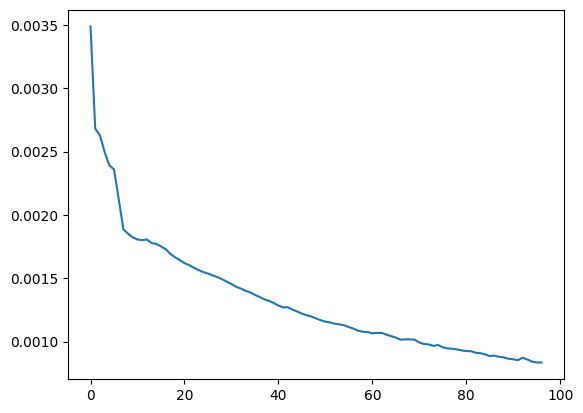

In [30]:
plt.plot(train_loss_list)

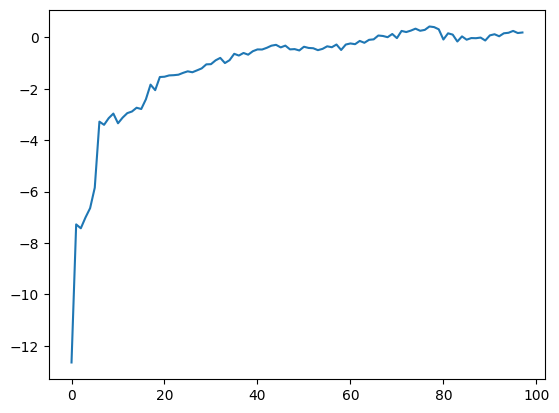

In [29]:
plt.plot(val_loss_list)

In [31]:
torch.save(model.state_dict(), "../model.pth")

In [32]:
model_load = WaveUNet().to(device)
model_load.load_state_dict(torch.load("../model.pth"))

<All keys matched successfully>

In [ ]:
val(valid_dataloader, model_load, test_loss_fn)

In [103]:
song_index = 18
test_arr = torch.Tensor(test_ds[song_index][0]).to(device)
test_arr = torch.unsqueeze(test_arr, 0)

model_load.eval()
with torch.no_grad():
    pred = model_load(test_arr)

pred = pred.cpu()

In [104]:
print(test_loss_fn(pred[0][0], torch.Tensor(test_ds[song_index][1][0]))[0].item(),
      test_loss_fn(pred[0][1], torch.Tensor(test_ds[song_index][1][1]))[0].item(),
      test_loss_fn(pred[0][2], torch.Tensor(test_ds[song_index][1][2]))[0].item(),
      test_loss_fn(pred[0][3], torch.Tensor(test_ds[song_index][1][3]))[0].item())


-16.60931396484375 9.919690132141113 -5.403880596160889 1.3881580829620361


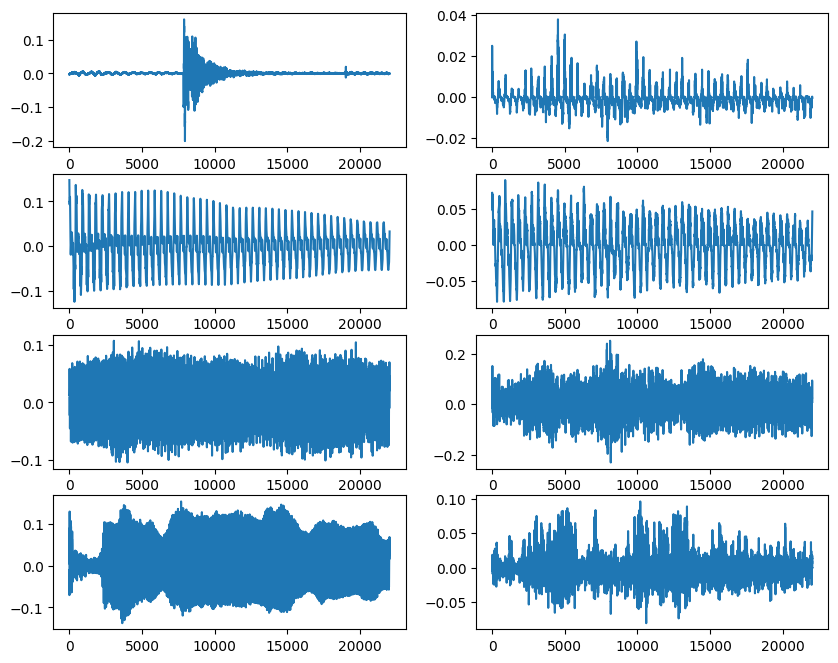

In [105]:
plt.figure(figsize=(10, 8))

for i in range(4):
    plt.subplot(4, 2, i*2+1)
    plt.plot(test_ds[song_index][1][i])
    plt.subplot(4, 2, i*2+2)
    plt.plot(pred[0][i])
plt.show()

for i in range(4):
    soundfile.write(f'./output/test_orign_{i}.wav', test_ds[song_index][1][i], 22050, format='wav')
    soundfile.write(f'./output/test_out_{i}.wav', pred[0][i], 22050, format='wav')

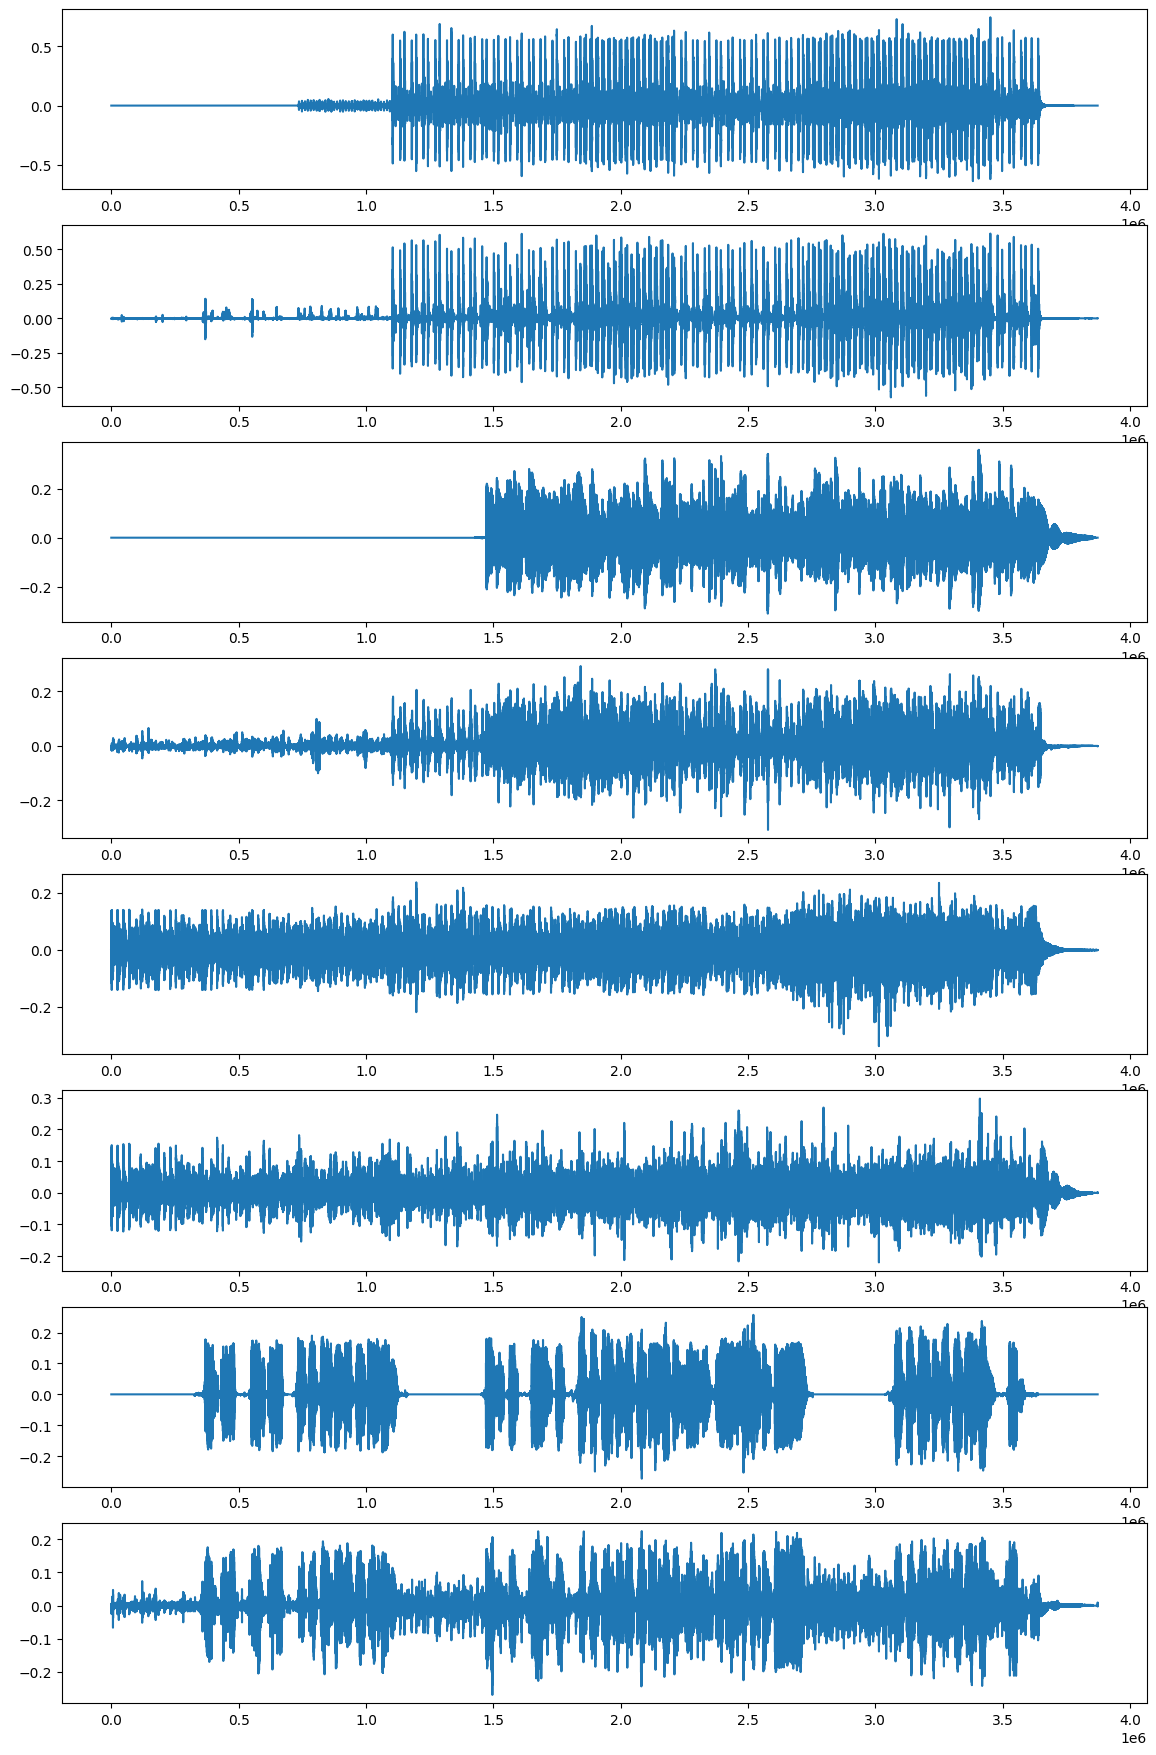

In [107]:
songname = 'Tom McKenzie - Directions'
song = np.load(f'../dataset/createdmusdb18/test/data_numpy/{songname}.stem.0.mp3.npy')
song = torch.Tensor(song.reshape(1, 1, -1)).to(device)
song_stem1 = np.load(f'../dataset/createdmusdb18/test/data_numpy/{songname}.stem.1.mp3.npy')
song_stem2 = np.load(f'../dataset/createdmusdb18/test/data_numpy/{songname}.stem.2.mp3.npy')
song_stem3 = np.load(f'../dataset/createdmusdb18/test/data_numpy/{songname}.stem.3.mp3.npy')
song_stem4 = np.load(f'../dataset/createdmusdb18/test/data_numpy/{songname}.stem.4.mp3.npy')
song_stems = [song_stem1, song_stem2, song_stem3, song_stem4]

model_load.eval()
with torch.no_grad():
    pred = model_load(song)

pred = pred.cpu()

plt.figure(figsize=(14, 22))

for i in range(4):
    plt.subplot(8, 1, i*2+1)
    plt.plot(song_stems[i])
    plt.subplot(8, 1, i*2+2)
    plt.plot(pred[0][i])
plt.show()

In [108]:
for i in range(4):
    soundfile.write(f'./output/song_orign_{i}.wav', song_stems[i], 22050, format='wav')
    soundfile.write(f'./output/song_out_{i}.wav', pred[0][i], 22050, format='wav')